In [136]:
# %pip install pandas
# %pip install pyarrow
# %pip install matplotlib
# %pip install statsmodels

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True 
plt.rcParams['figure.figsize'] = (20,6)

In [138]:
df = pd.read_csv('Dataset/Used_data.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Holiday,Profit,Age Group,Month,Year,Year-Month,Income Group
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,non Holiday,57.315,25-29,1,2016,2016-01,8000 - 14999
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,non Holiday,23.666,25-29,1,2016,2016-01,8000 - 14999
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,non Holiday,27.568,50-54,1,2016,2016-01,8000 - 14999
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,non Holiday,25.798,18-24,1,2016,2016-01,22000 - 34999
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,non Holiday,16.844,30-34,1,2016,2016-01,8000 - 14999


I want to make a profit prediction, from the analysis that has been done previously, I will use the time series. The profit line plot shows that there is a trend in certain months, therefore, I will use the SARIMA (Seasonal ARIMA) algorithm

<div style="text-align:center">
    <img src="Profit per month.png" alt="Profit per month" style="width:700px;" />
</div>

In [139]:
df_SARIMA = df[['Year-Month', 'Profit']]
df_SARIMA.head()

,Year-Month,Profit
0,2016-01,57.315
1,2016-01,23.666
2,2016-01,27.568
3,2016-01,25.798
4,2016-01,16.844


In [140]:
df_SARIMA.dtypes

Year-Month     object
Profit        float64
dtype: object

Make the `Date of Travel` as Datetime

In [141]:
df_SARIMA['Year-Month'] = pd.to_datetime(df_SARIMA['Year-Month'])
df_SARIMA.dtypes

Year-Month    datetime64[ns]
Profit               float64
dtype: object

In [142]:
df_SARIMA_grouped = df_SARIMA.groupby(['Year-Month']).agg({'Profit':'sum'}).reset_index()
df_SARIMA_grouped.head()

,Year-Month,Profit
0,2016-01-01,9.102610e+05
1,2016-02-01,1.096645e+06
2,2016-03-01,1.002566e+06
3,2016-04-01,1.028728e+06
4,2016-05-01,1.344324e+06


Set `Date of Travel` to index

In [143]:
df_SARIMA = df_SARIMA_grouped.set_index('Year-Month')
df_SARIMA.sort_index(inplace=True)
df_SARIMA.head()

,Profit
Year-Month,
2016-01-01,9.102610e+05
2016-02-01,1.096645e+06
2016-03-01,1.002566e+06
2016-04-01,1.028728e+06
2016-05-01,1.344324e+06


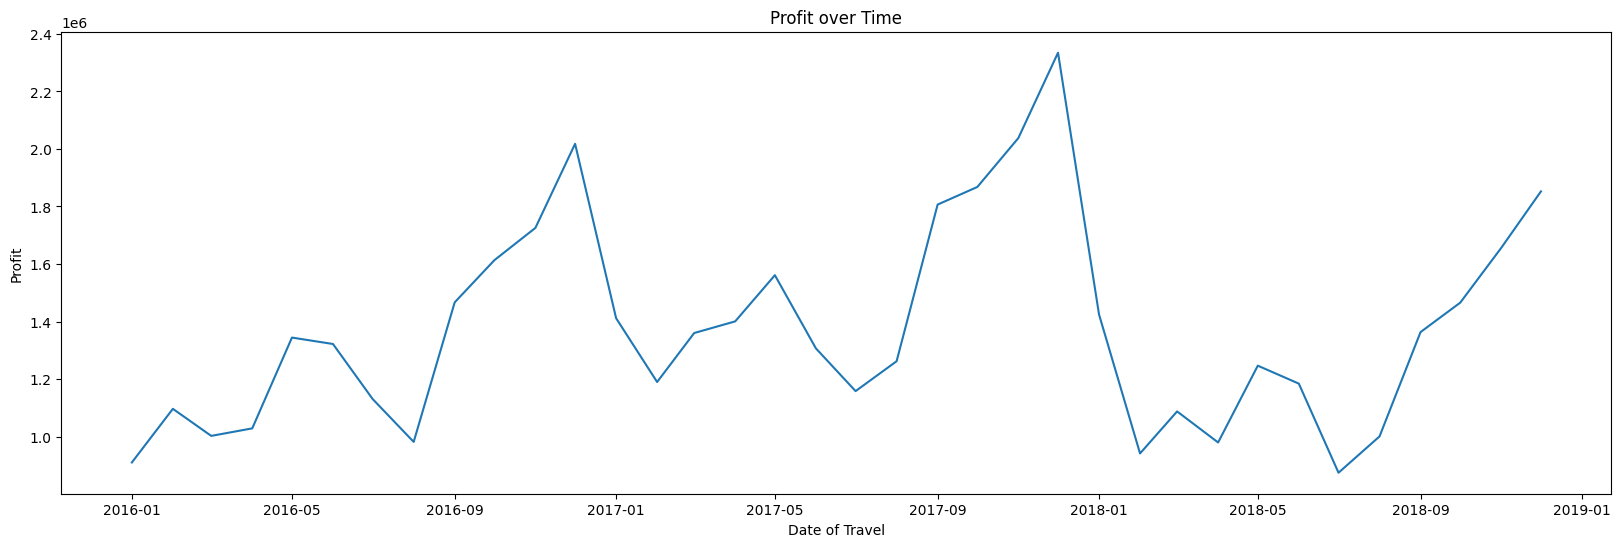

In [144]:

plt.plot(df_SARIMA.index, df_SARIMA['Profit'], linestyle='-')
plt.title('Profit over Time')
plt.xlabel('Date of Travel')
plt.ylabel('Profit')
plt.show()

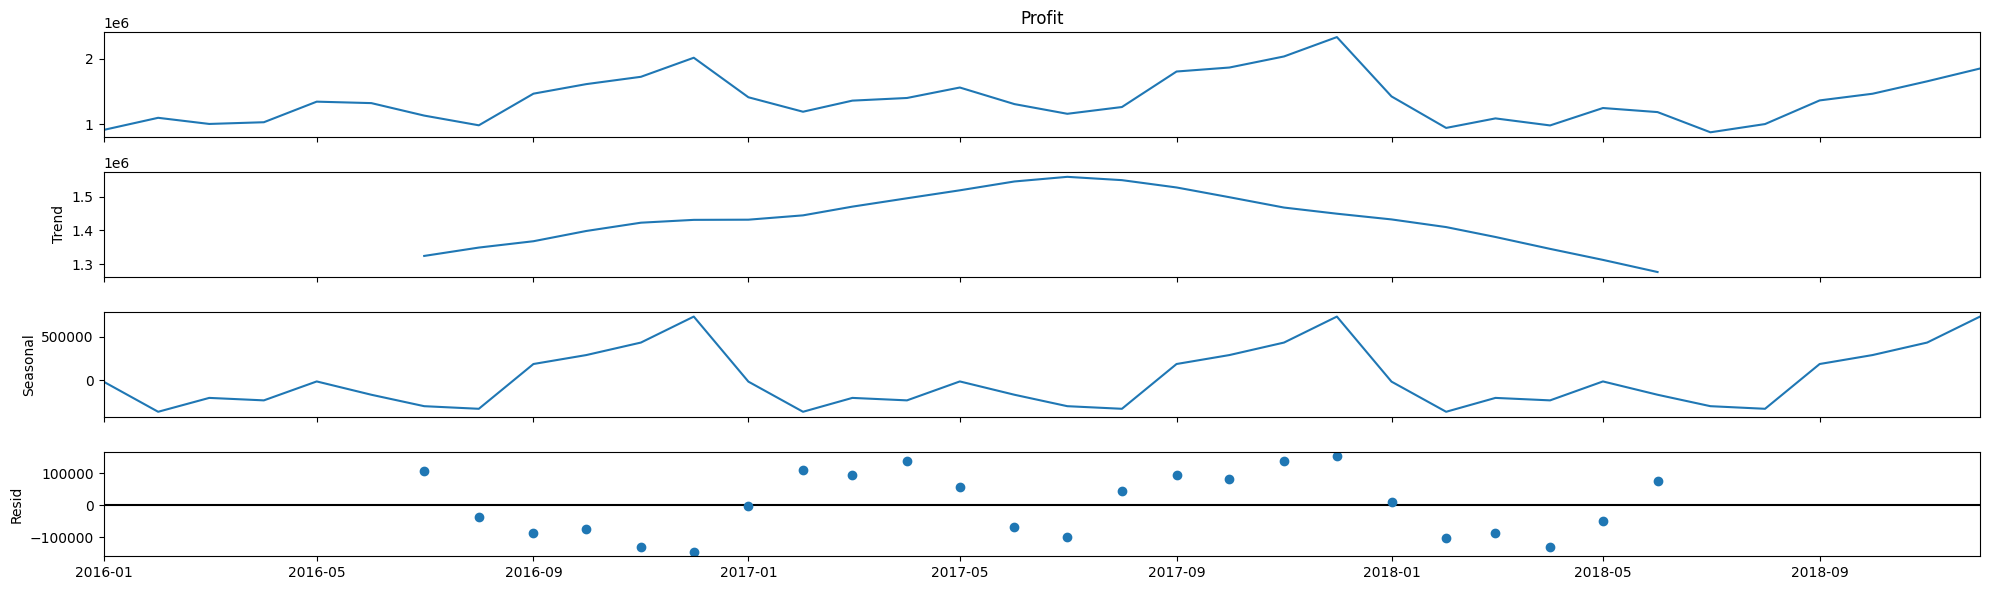

In [145]:
decompose_data = seasonal_decompose(df_SARIMA['Profit'], model='additive', period=12)
decompose_data.plot()
plt.show()

<Axes: xlabel='Year-Month'>

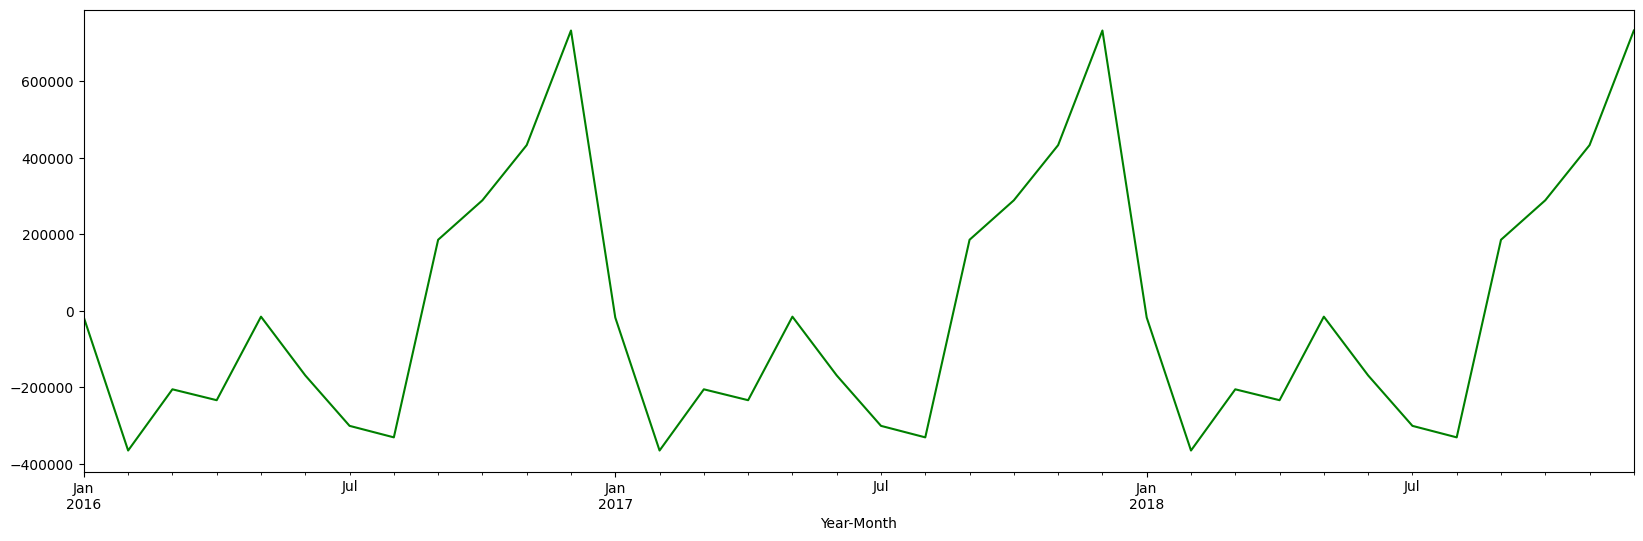

In [146]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

where if the p-value is less than 0.05, then we can consider the time series is stationary, and if the P-value is greater than 0.05, then the time series is non-stationary.

In [147]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_SARIMA['Profit'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)


1. ADF :  -0.7392674304468099
2. P-Value :  0.8363145802335934
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 25
5. Critical Values :
	 1% :  -3.7238633119999998
	 5% :  -2.98648896
	 10% :  -2.6328004


The P-value higher than 0.05, the data is stationary, right decision to use SARIMA

In [148]:
train_size = int(len(df_SARIMA)*0.8)
train, test = df_SARIMA[:train_size], df_SARIMA[train_size:]

train.shape, test.shape

((28, 1), (8, 1))

Modeling

In [166]:
order = (1,1,1) # non seasonal
seasonal_order = (1,3,1,12) # seasonal order with 12 period (yearly)

model = SARIMAX(train['Profit'], order=order, seasonal_order=seasonal_order)
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [167]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Profit   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 3, 1, 12)   Log Likelihood                   0.000
Date:                            Fri, 16 Feb 2024   AIC                             10.000
Time:                                    20:00:42   BIC                                nan
Sample:                                01-01-2016   HQIC                               nan
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<Axes: >

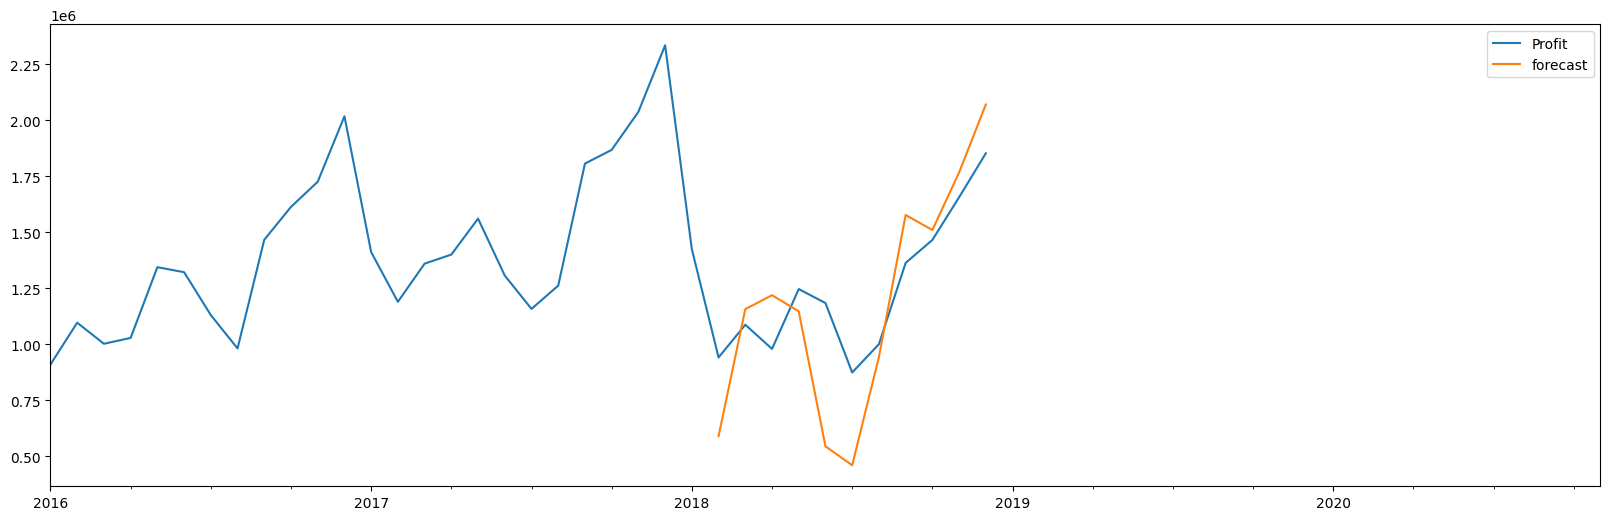

In [168]:
# forecast = results.get_forecast(steps=len(test))
df_SARIMA['forecast'] = results.predict(start=25, end=35, dynamic=True)
df_SARIMA[['Profit', 'forecast']].plot()

In [169]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_SARIMA.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [170]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=df_SARIMA.columns)
pred_date.head()

,Profit,forecast
2020-12-01,NaN,NaN
2021-01-01,NaN,NaN
2021-02-01,NaN,NaN
2021-03-01,NaN,NaN
2021-04-01,NaN,NaN


In [171]:
df_SARIMA=pd.concat([df_SARIMA,pred_date])
df_SARIMA.head()

,Profit,forecast
2016-01-01,9.102610e+05,NaN
2016-02-01,1.096645e+06,NaN
2016-03-01,1.002566e+06,NaN
2016-04-01,1.028728e+06,NaN
2016-05-01,1.344324e+06,NaN


<Axes: >

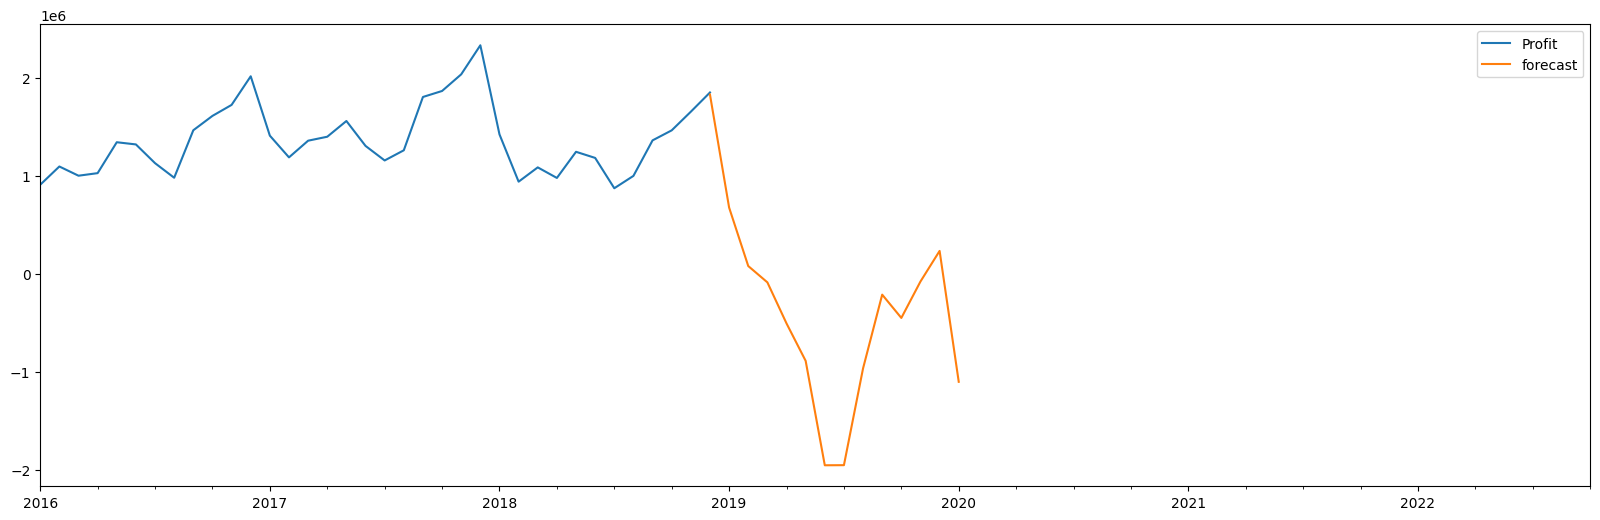

In [176]:
df_SARIMA['forecast'] = results.predict(start=35, end=48, dynamic= True)  
df_SARIMA[['Profit', 'forecast']].plot()

Analysis p, d, q

In [177]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Plot ACF dan PACF
# plot_acf(df['Profit'])
# plot_pacf(df['Profit'])
# plt.show()

In [111]:
# df_diff = df['Profit'].diff().dropna()

# # Plot hasil diferensiasi
# plt.plot(df_diff)
# plt.title('Differenced Profit')
# plt.show()

In [164]:
# import itertools

# # Parameter yang akan diuji
# p = d = q = range(1, 5)
# S = 12
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], S) for x in pdq]

# # Grid search untuk pemilihan parameter terbaik
# best_aic = float("inf")
# best_params = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = SARIMAX(train['Profit'], order=param, seasonal_order=param_seasonal)
#             results = model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_params = (param, param_seasonal)
#         except:
#             continue

# print(f"Best AIC: {best_aic}")
# print(f"Best Parameters: {best_params}")


Best AIC: 10.0
Best Parameters: ((1, 1, 1), (1, 3, 1, 12))


Best AIC: 10.0


Best Parameters: ((1, 1, 1), (1, 3, 1, 12))

In [113]:
# mse = ((forecast.predicted_mean - test['Profit']) ** 2).mean()
# rmse = mse ** 0.5
# print(f"RMSE: {rmse}")